In [593]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# models
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

In [205]:
df = pd.read_csv("nyc-rolling-sales.csv")

In [206]:
df

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,...,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,...,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,...,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,...,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


In [207]:
# check the shape of our dataset: 84548 rows and 22 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

# 01. Data Clean

### Let's convert some of the columns to appropriate datatype

In [208]:
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
#df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

### Check missing value: we don't have missing values

In [209]:
df.isna().sum()

Unnamed: 0                            0
BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                  0
BLOCK                                 0
LOT                                   0
EASE-MENT                             0
BUILDING CLASS AT PRESENT             0
ADDRESS                               0
APARTMENT NUMBER                      0
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  26252
GROSS SQUARE FEET                 27612
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                        14561
SALE DATE                             0
dtype: int64

### Drop rows that don't have the SALE PRICE

In [210]:
# drop samples that don't have the SALE PRICE
df = df[~df['SALE PRICE'].isna()]
df

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00
6,10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,...,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00
9,13,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,...,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,...,2,0,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,...,2,0,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,...,2,0,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,...,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0,2016-12-21 00:00:00


### Use mean value to replace missing values of "LAND SQUARE FEET" and "GROSS SQUARE FEET" columns

In [211]:
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

*  Check missing values again ↓

In [212]:
df.isna().sum()

Unnamed: 0                        0
BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
EASE-MENT                         0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
APARTMENT NUMBER                  0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64

### drop the "Unnamed: 0", it seems not useful

In [213]:
df = df.drop(["Unnamed: 0"], axis=1)
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,,...,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,,...,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,,...,2,0,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28 00:00:00
84544,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,,...,2,0,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21 00:00:00
84545,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,,...,2,0,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05 00:00:00
84546,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,,...,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0,2016-12-21 00:00:00


### Drop "EASE-MENT" column,it doesn't contain any information

In [214]:
df['EASE-MENT'].value_counts()

     69987
Name: EASE-MENT, dtype: int64

In [215]:
# drop "EASE-MENT" column
df = df.drop(["EASE-MENT"], axis=1)
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,,10009,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,B9,37 QUAIL LANE,,10309,2,0,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28 00:00:00
84544,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,B9,32 PHEASANT LANE,,10309,2,0,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21 00:00:00
84545,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,B2,49 PITNEY AVENUE,,10309,2,0,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05 00:00:00
84546,5,WOODROW,22 STORE BUILDINGS,4,7100,28,K6,2730 ARTHUR KILL ROAD,,10309,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0,2016-12-21 00:00:00


## Check outliers

In [216]:
df.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,69987.000000,6.998700e+04,6.998700e+04,69987.000000,6.998700e+04
mean,4196.072528,373.828397,10741.455185,1.899553,0.172489,2.092203,3.629395e+03,3.672552e+03,1799.348236,1.276456e+06
std,3429.196524,656.096528,1263.234938,14.549545,9.123717,17.276100,3.369949e+04,2.447312e+04,520.884552,1.140526e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1348.000000,22.000000,10306.000000,0.000000,0.000000,0.000000,1.900000e+03,1.268000e+03,1920.000000,2.250000e+05
50%,3378.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.946000e+03,2.400000e+03,1937.000000,5.300000e+05
75%,6186.000000,709.000000,11249.000000,2.000000,0.000000,2.000000,3.629395e+03,3.672552e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


#### there's some problems in "YEAR BUILT" column

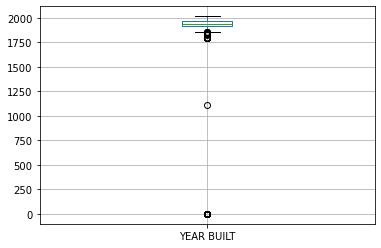

In [217]:
df.boxplot(column = ['YEAR BUILT'])

In [218]:
df['YEAR BUILT'].value_counts()

0       5391
1920    4974
1930    4214
1925    3646
1910    3078
        ... 
1883       1
1849       1
1855       1
1111       1
1891       1
Name: YEAR BUILT, Length: 155, dtype: int64

In [219]:
# many 'YEAR BUILT' are 0 or less than 1700, it doesn't make sense, we drop them
df = df.loc[df['YEAR BUILT'] >1700,]
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,,10009,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,B9,37 QUAIL LANE,,10309,2,0,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28 00:00:00
84544,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,B9,32 PHEASANT LANE,,10309,2,0,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21 00:00:00
84545,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,B2,49 PITNEY AVENUE,,10309,2,0,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05 00:00:00
84546,5,WOODROW,22 STORE BUILDINGS,4,7100,28,K6,2730 ARTHUR KILL ROAD,,10309,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0,2016-12-21 00:00:00


### Sales price

In [220]:
df['SALE PRICE'].describe()

count    6.459500e+04
mean     1.263354e+06
std      1.166054e+07
min      0.000000e+00
25%      2.370000e+05
50%      5.300000e+05
75%      9.358855e+05
max      2.210000e+09
Name: SALE PRICE, dtype: float64

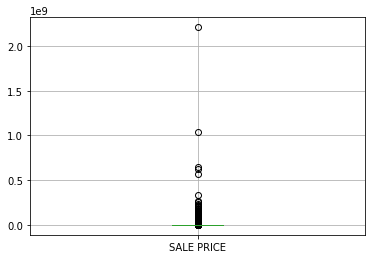

In [221]:
df.boxplot(column = ['SALE PRICE'])

In [222]:
# many 'SALE PRICE' are less than 100,000 or more than 20,000,000. We drop them
df = df[(df['SALE PRICE'] > 100000) & (df['SALE PRICE'] < 20000000)]

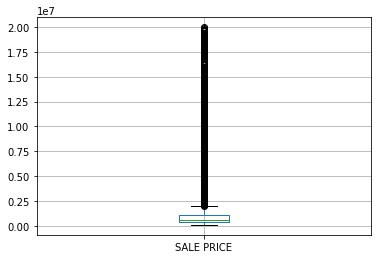

In [223]:
df.boxplot(column = ['SALE PRICE'])

#### check others

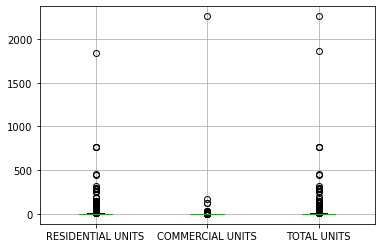

In [301]:
df.boxplot(column = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS','TOTAL UNITS'])

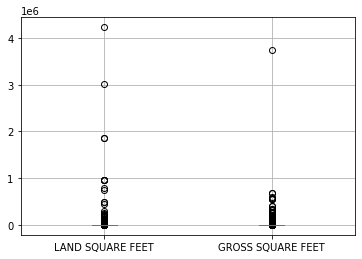

In [302]:
df.boxplot(column = ['LAND SQUARE FEET','GROSS SQUARE FEET'])

# 02. Data engineering

### Building Class at Present column
 The first position of the Building Class is a letter that is used to describe a general class of properties (for
example “A” signifies one-family homes, “O” signifies office buildings. “R” signifies
condominiums). The second position, a number, adds more specific information about the
property’s use or construction style (using our previous examples “A0” is a Cape Cod style
one family home, “O4” is a tower type office building and “R5” is a commercial condominium
unit).

## SALE DATE

In [317]:
# convert sale date column from categorical to date
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
# create columns to contain the year, month, day, day_of_week for further analysis
df['year'] = df['SALE DATE'].dt.year
df['month'] = df['SALE DATE'].dt.month
df['day'] = df['SALE DATE'].dt.day
df['day_of_week'] = df['SALE DATE'].dt.dayofweek

# 03. EDA

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52766 entries, 0 to 84546
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         52766 non-null  category
 1   NEIGHBORHOOD                    52766 non-null  object  
 2   BUILDING CLASS CATEGORY         52766 non-null  object  
 3   TAX CLASS AT PRESENT            52766 non-null  category
 4   BLOCK                           52766 non-null  int64   
 5   LOT                             52766 non-null  int64   
 6   BUILDING CLASS AT PRESENT       52766 non-null  object  
 7   ADDRESS                         52766 non-null  object  
 8   APARTMENT NUMBER                52766 non-null  object  
 9   ZIP CODE                        52766 non-null  int64   
 10  RESIDENTIAL UNITS               52766 non-null  int64   
 11  COMMERCIAL UNITS                52766 non-null  int64   
 12  TOTAL UNITS       

### Part01: Check numeric data

In [225]:
numeric_list = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS','TOTAL UNITS', 'LAND SQUARE FEET','GROSS SQUARE FEET',
                     'YEAR BUILT', 'SALE PRICE']

### SALE PRICE!!

In [227]:
df['SALE PRICE'].describe()

count    5.276600e+04
mean     1.126632e+06
std      1.772830e+06
min      1.003350e+05
25%      4.000000e+05
50%      6.400000e+05
75%      1.060000e+06
max      1.997544e+07
Name: SALE PRICE, dtype: float64

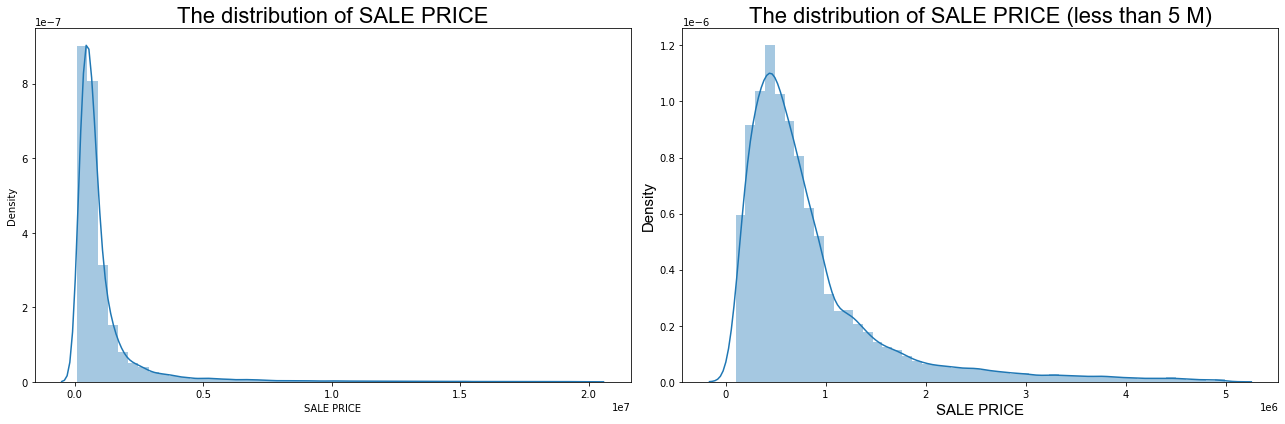

In [243]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(df['SALE PRICE'],kde = True, ax=ax[0])
ax[0].set_title('The distribution of SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 22})
plt.xlabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})


sns.distplot(df.loc[df['SALE PRICE']<5000000,['SALE PRICE']],kde = True, ax=ax[1])
ax[1].set_title('The distribution of SALE PRICE (less than 5 M)', fontdict={'fontname': 'Arial', 'fontsize': 22})
plt.xlabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

### YEAR BUILT

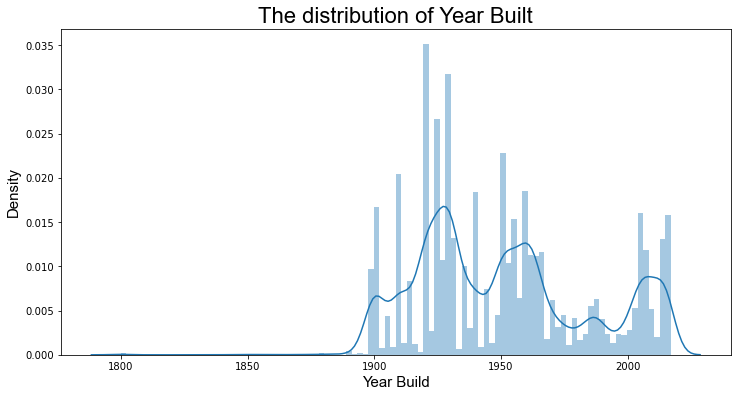

In [226]:
fig, ax = plt.subplots(figsize=(12,6))

sns.distplot(df['YEAR BUILT'],bins = 100,kde = True)

plt.title('The distribution of Year Built', fontdict={'fontname': 'Arial', 'fontsize': 22})
plt.xlabel('Year Build', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.show()

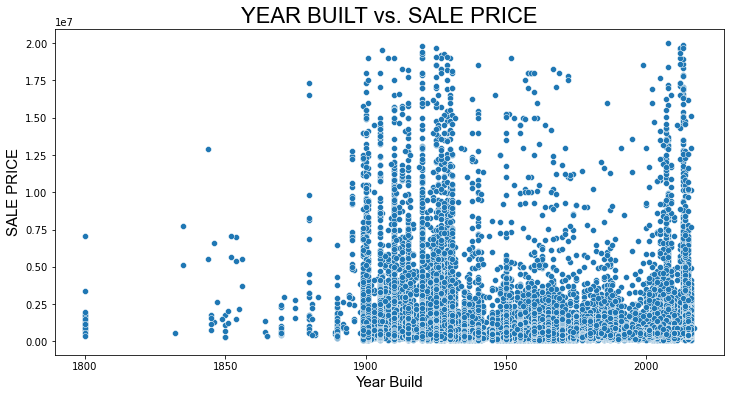

In [328]:
fig, ax = plt.subplots(figsize=(12,6))

sns.scatterplot( x="YEAR BUILT", y="SALE PRICE", data=df)

plt.title('YEAR BUILT vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 22})
plt.xlabel('Year Build', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.show()

## RESIDENTIAL UNITS

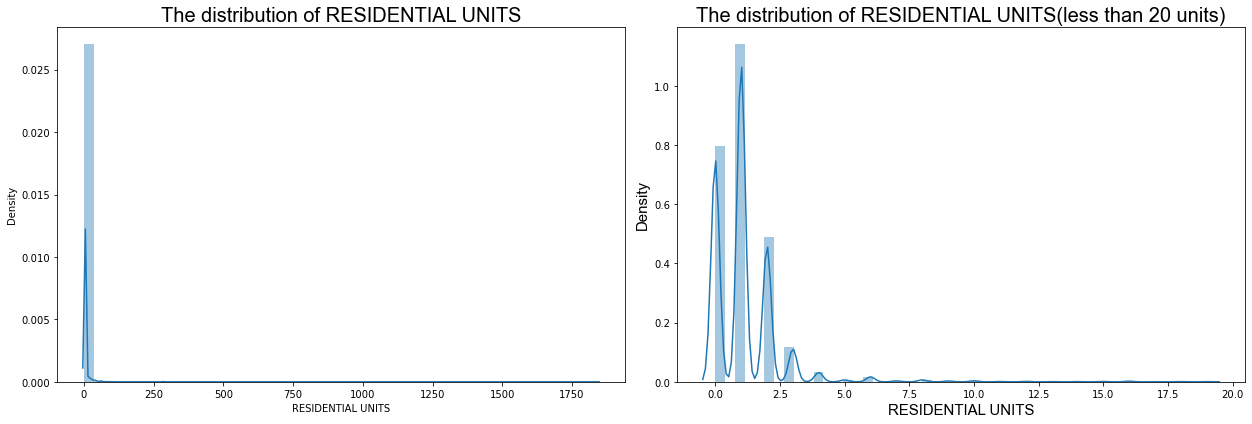

In [340]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(df['RESIDENTIAL UNITS'],kde = True, ax=ax[0])
ax[0].set_title('The distribution of RESIDENTIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.xlabel('RESIDENTIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})


sns.distplot(df.loc[df['RESIDENTIAL UNITS']<20,['RESIDENTIAL UNITS']],kde = True, ax=ax[1])
ax[1].set_title('The distribution of RESIDENTIAL UNITS(less than 20 units)', fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.xlabel('RESIDENTIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

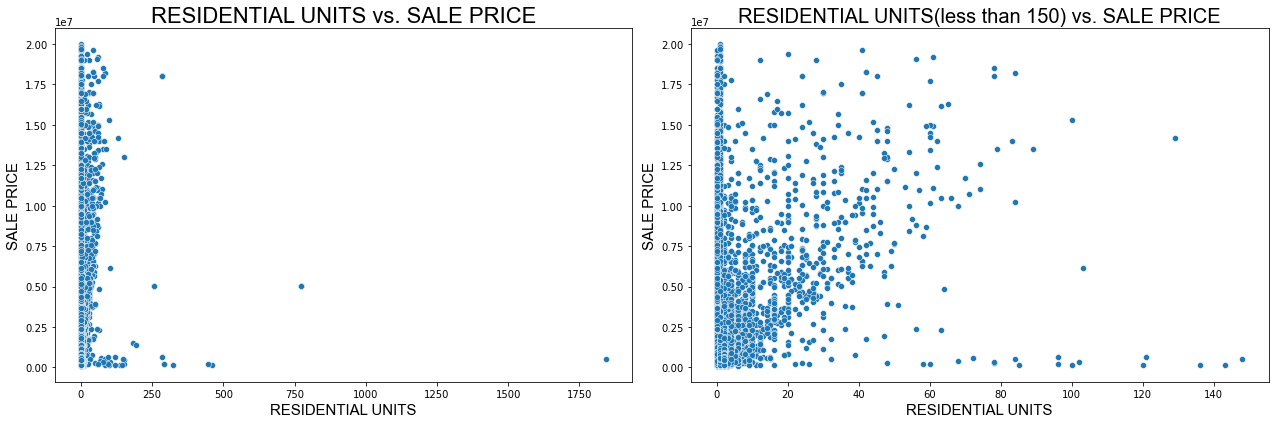

In [342]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(x="RESIDENTIAL UNITS", y="SALE PRICE", data=df, ax=ax[0])
ax[0].set_title('RESIDENTIAL UNITS vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 22})
ax[0].set_xlabel('RESIDENTIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[0].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

sns.scatterplot(x=df.loc[df['RESIDENTIAL UNITS']<150,'RESIDENTIAL UNITS'], y=df["SALE PRICE"], ax=ax[1])
ax[1].set_title('RESIDENTIAL UNITS(less than 150) vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[1].set_xlabel('RESIDENTIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

## COMMERCIAL UNITS

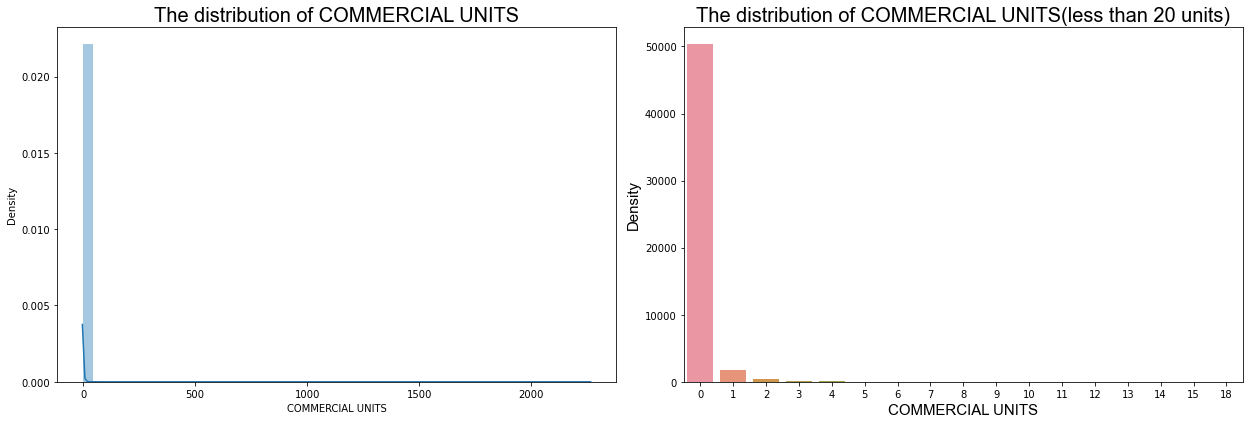

In [270]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(df['COMMERCIAL UNITS'],kde = True, ax=ax[0])
ax[0].set_title('The distribution of COMMERCIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.xlabel('COMMERCIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})


sns.countplot(x=df.loc[df['COMMERCIAL UNITS']<20,'COMMERCIAL UNITS'], ax=ax[1])
ax[1].set_title('The distribution of COMMERCIAL UNITS(less than 20 units)', fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.xlabel('COMMERCIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

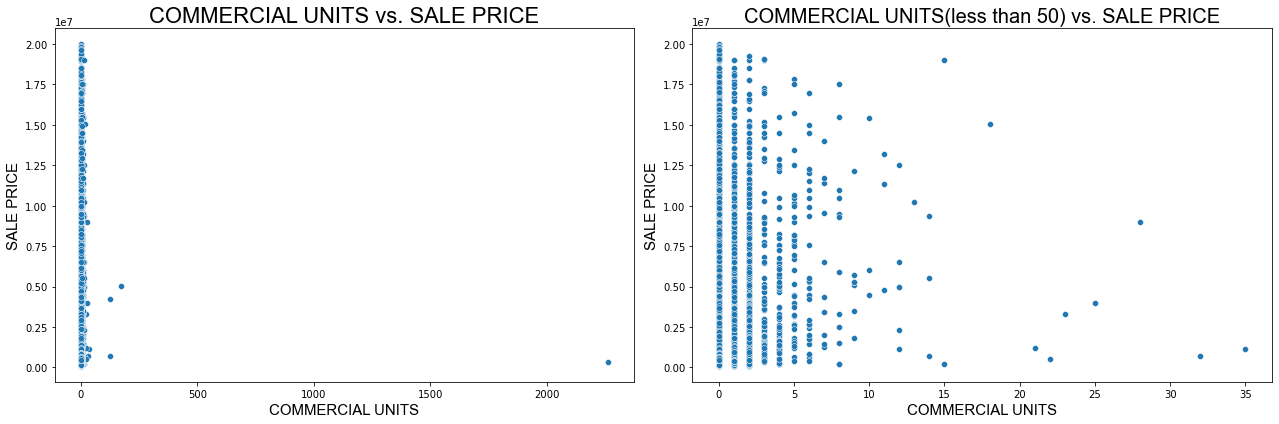

In [345]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(x="COMMERCIAL UNITS", y="SALE PRICE", data=df, ax=ax[0])
ax[0].set_title('COMMERCIAL UNITS vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 22})
ax[0].set_xlabel('COMMERCIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[0].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

sns.scatterplot(x=df.loc[df['COMMERCIAL UNITS']<50,'COMMERCIAL UNITS'], y=df["SALE PRICE"], ax=ax[1])
ax[1].set_title('COMMERCIAL UNITS(less than 50) vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[1].set_xlabel('COMMERCIAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

## TOTAL UNITS

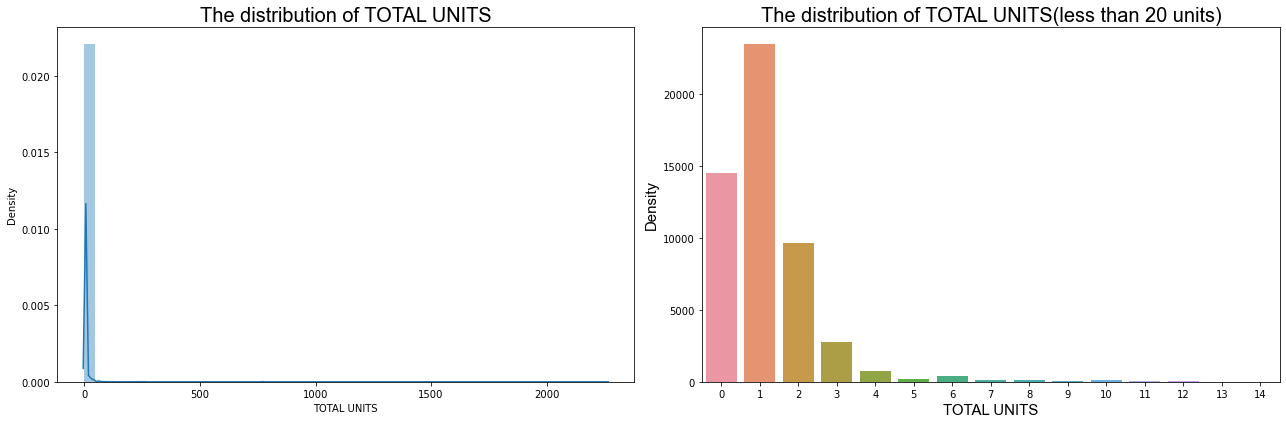

In [278]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(df['TOTAL UNITS'],kde = True, ax=ax[0])
ax[0].set_title('The distribution of TOTAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.xlabel('TOTAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})


sns.countplot(x=df.loc[df['TOTAL UNITS']<15,'TOTAL UNITS'], ax=ax[1])
ax[1].set_title('The distribution of TOTAL UNITS(less than 20 units)', fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.xlabel('TOTAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

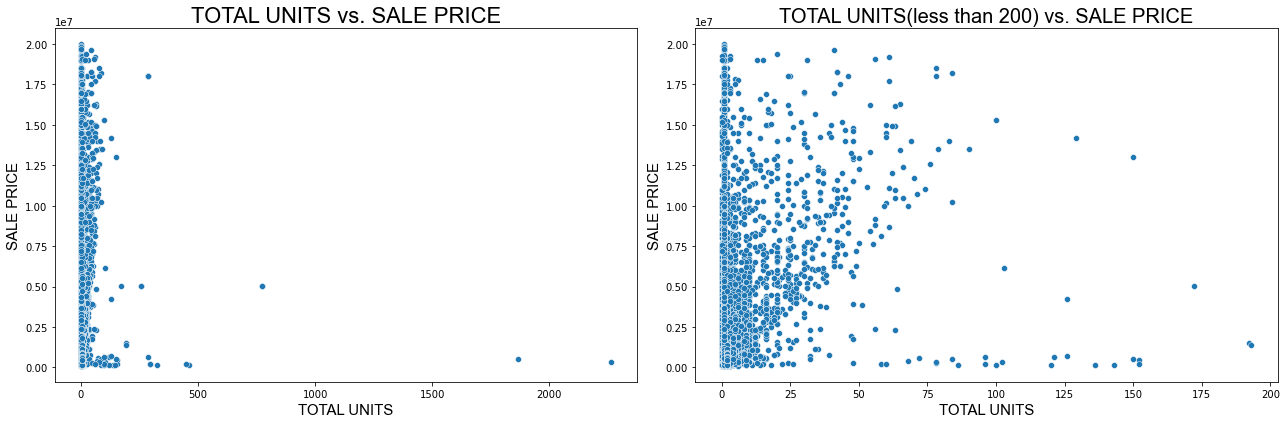

In [357]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(x="TOTAL UNITS", y="SALE PRICE", data=df, ax=ax[0])
ax[0].set_title('TOTAL UNITS vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 22})
ax[0].set_xlabel('TOTAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[0].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

sns.scatterplot(x=df.loc[df['TOTAL UNITS']<200,'TOTAL UNITS'], y=df["SALE PRICE"], ax=ax[1])
ax[1].set_title('TOTAL UNITS(less than 200) vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[1].set_xlabel('TOTAL UNITS', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

## LAND SQUARE FEET

In [351]:
df['LAND SQUARE FEET'].quantile(.95)

5200.0

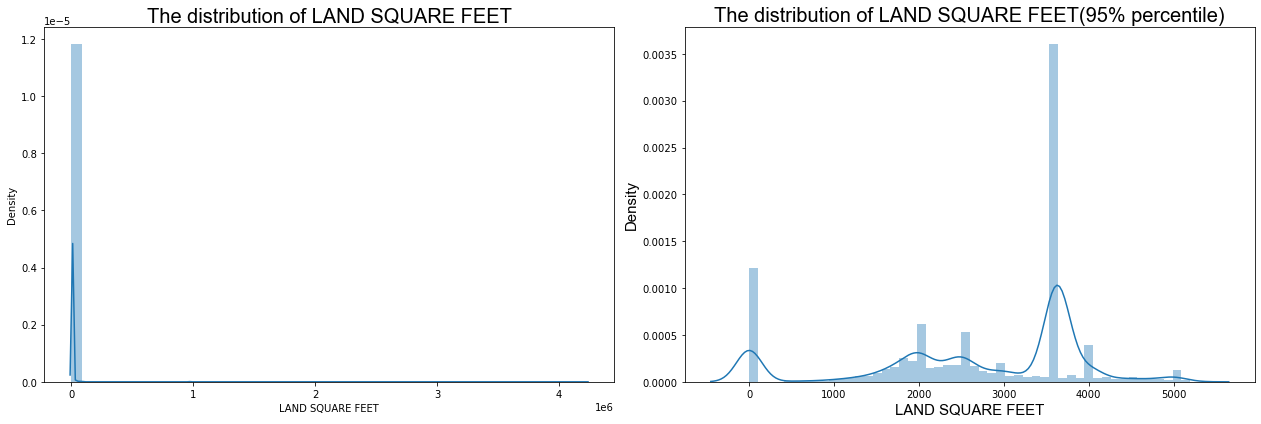

In [292]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(df['LAND SQUARE FEET'],kde = True, ax=ax[0])
ax[0].set_title('The distribution of LAND SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.xlabel('LAND SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})


# sns.countplot(x=df.loc[df['LAND SQUARE FEET'] < df['LAND SQUARE FEET'].quantile(.95),'LAND SQUARE FEET'], ax=ax[1])
sns.distplot(df.loc[df['LAND SQUARE FEET'] < df['LAND SQUARE FEET'].quantile(.95),'LAND SQUARE FEET'],kde = True, ax=ax[1])
ax[1].set_title('The distribution of LAND SQUARE FEET(95% percentile)', fontdict={'fontname': 'Arial', 'fontsize': 20})
plt.xlabel('LAND SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

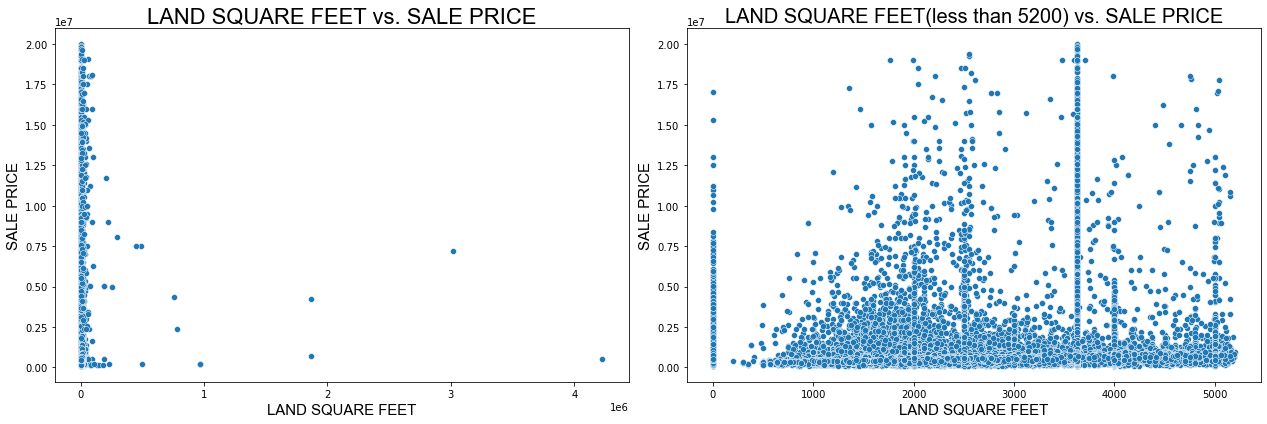

In [352]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(x="LAND SQUARE FEET", y="SALE PRICE", data=df, ax=ax[0])
ax[0].set_title('LAND SQUARE FEET vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 22})
ax[0].set_xlabel('LAND SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[0].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

sns.scatterplot(x=df.loc[df['LAND SQUARE FEET']<5200,'LAND SQUARE FEET'], y=df["SALE PRICE"], ax=ax[1])
ax[1].set_title('LAND SQUARE FEET(less than 5200) vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[1].set_xlabel('LAND SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

## GROSS SQUARE FEET

In [354]:
df['GROSS SQUARE FEET'].quantile(.95)

3900.0

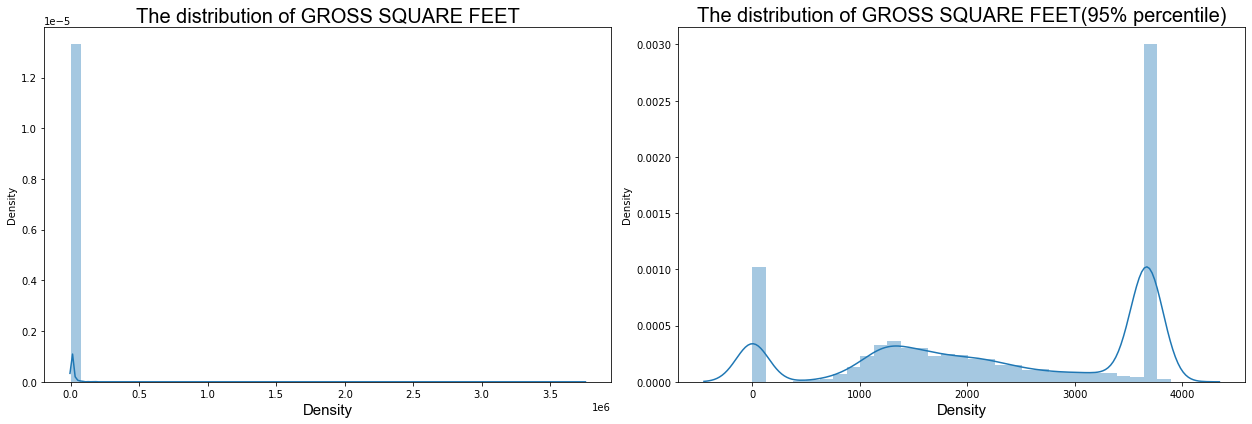

In [300]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(df['GROSS SQUARE FEET'],kde = True, ax=ax[0])
ax[0].set_title('The distribution of GROSS SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[0].set_xlabel('GROSS SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[0].set_ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})


# sns.countplot(x=df.loc[df['GROSS SQUARE FEET'] < df['GROSS SQUARE FEET'].quantile(.95),'GROSS SQUARE FEET'], ax=ax[1])
sns.distplot(df.loc[df['GROSS SQUARE FEET'] < df['GROSS SQUARE FEET'].quantile(.95),'GROSS SQUARE FEET'],kde = True, ax=ax[1])
ax[1].set_title('The distribution of GROSS SQUARE FEET(95% percentile)', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[1].set_xlabel('GROSS SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_ylabel('Density', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

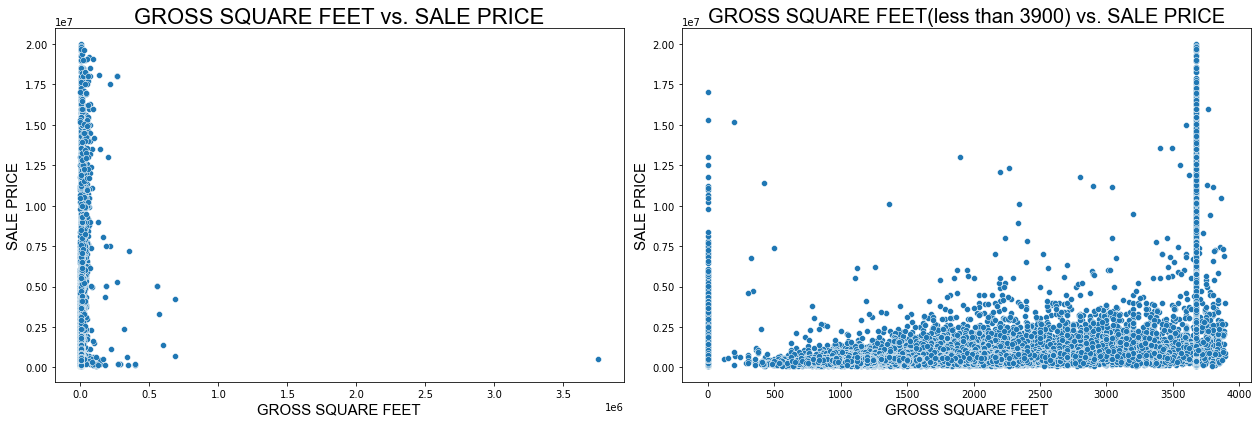

In [355]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.scatterplot(x="GROSS SQUARE FEET", y="SALE PRICE", data=df, ax=ax[0])
ax[0].set_title('GROSS SQUARE FEET vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 22})
ax[0].set_xlabel('GROSS SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[0].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

sns.scatterplot(x=df.loc[df['GROSS SQUARE FEET']<3900,'GROSS SQUARE FEET'], y=df["SALE PRICE"], ax=ax[1])
ax[1].set_title('GROSS SQUARE FEET(less than 3900) vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[1].set_xlabel('GROSS SQUARE FEET', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

### Part02:  Check categorical data

### BOROUGH
Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

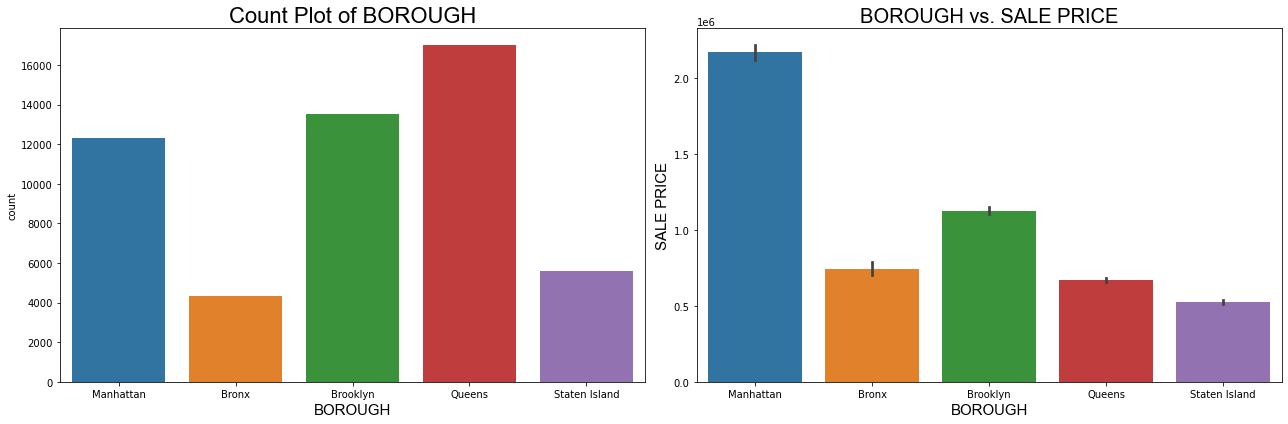

In [361]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

labels = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens','Staten Island']

sns.countplot(x='BOROUGH',data=df, ax=ax[0])
ax[0].set_title('Count Plot of BOROUGH', fontdict={'fontname': 'Arial', 'fontsize': 22})
ax[0].set_xlabel('BOROUGH', fontdict={'fontname': 'Arial', 'fontsize': 15})
# ax[0].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[0].set_xticklabels(labels)

sns.barplot(x='BOROUGH', y='SALE PRICE',data=df, ax=ax[1])
ax[1].set_title('BOROUGH vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[1].set_xlabel('BOROUGH', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_xticklabels(labels)

plt.tight_layout()
plt.show()

### TAX CLASS AT PRESENT
* Tax Class at Present:
Every property in the city is assigned to one of four tax classes (Classes 1, 2, 3, and 4),
based on the use of the property.

    • Class 1: Includes most residential property of up to three units (such as one-,
two-, and three-family homes and small stores or offices with one or two
attached apartments), vacant land that is zoned for residential use, and most
condominiums that are not more than three stories.

    • Class 2: Includes all other property that is primarily residential, such as
cooperatives and condominiums.

    • Class 3: Includes property with equipment owned by a gas, telephone or electric
company.

    • Class 4: Includes all other properties not included in class 1,2, and 3, such as
offices, factories, warehouses, garage buildings, etc.

In [367]:
## there's 2 empty values in this column, we drop them
df['TAX CLASS AT PRESENT']= df.loc[df['TAX CLASS AT PRESENT'] != " ",'TAX CLASS AT PRESENT']

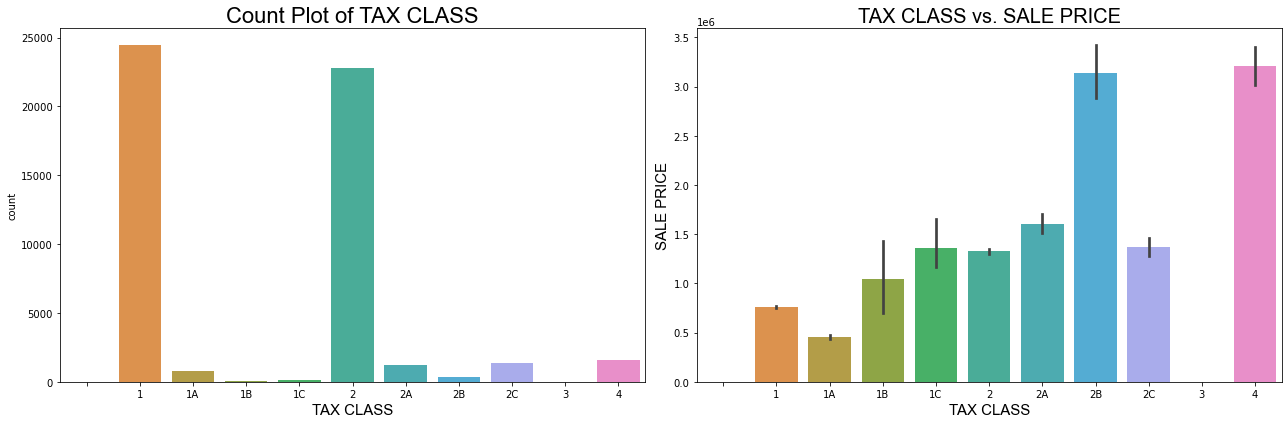

In [368]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# labels = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens','Staten Island']

sns.countplot(x='TAX CLASS AT PRESENT',data=df, ax=ax[0])
ax[0].set_title('Count Plot of TAX CLASS', fontdict={'fontname': 'Arial', 'fontsize': 22})
ax[0].set_xlabel('TAX CLASS', fontdict={'fontname': 'Arial', 'fontsize': 15})


sns.barplot(x='TAX CLASS AT PRESENT', y='SALE PRICE',data=df, ax=ax[1])
ax[1].set_title('TAX CLASS vs. SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 20})
ax[1].set_xlabel('TAX CLASS', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax[1].set_ylabel('SALE PRICE', fontdict={'fontname': 'Arial', 'fontsize': 15})

plt.tight_layout()
plt.show()

### SALE DATE

#### Year

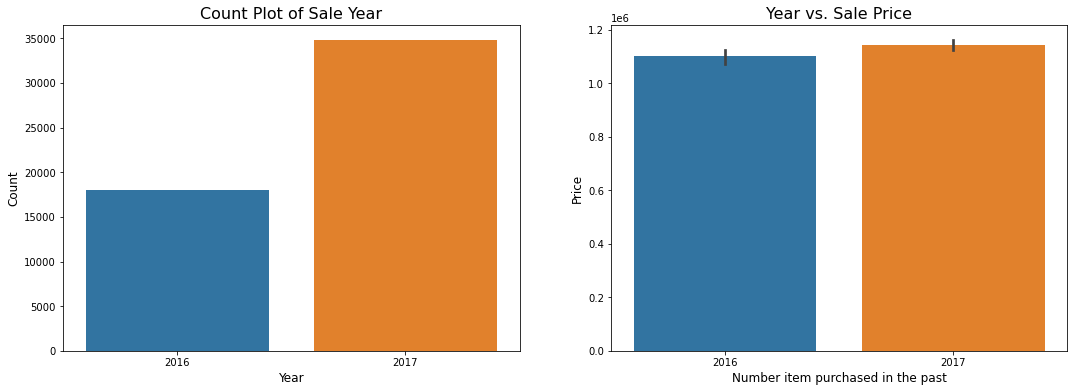

In [321]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='year',data=df, ax=ax[0])
ax[0].set_xlabel('Year', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Sale Year', fontsize=16)


sns.barplot(x='year', y='SALE PRICE',data=df, ax=ax[1])
ax[1].set_xlabel('Number item purchased in the past', fontsize=12)
ax[1].set_ylabel('Price', fontsize=12)
ax[1].set_title('Year vs. Sale Price', fontsize=16)
plt.show()

#### Month

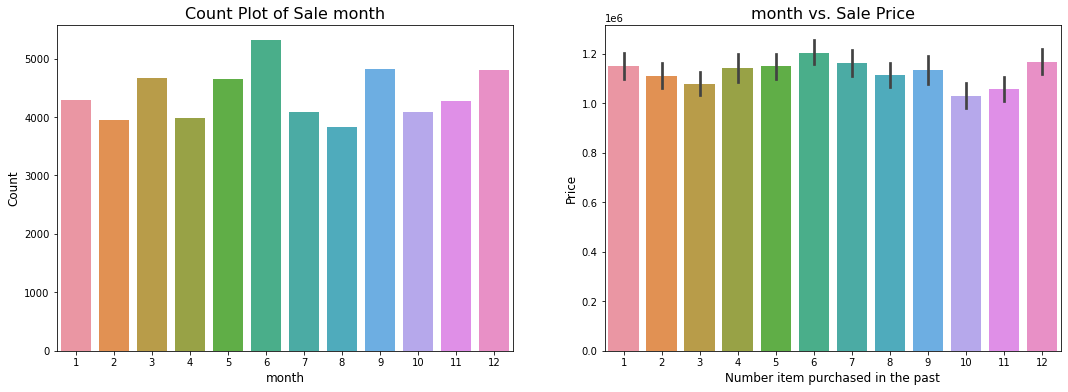

In [322]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='month',data=df, ax=ax[0])
ax[0].set_xlabel('month', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Sale month', fontsize=16)


sns.barplot(x='month', y='SALE PRICE',data=df, ax=ax[1])
ax[1].set_xlabel('Number item purchased in the past', fontsize=12)
ax[1].set_ylabel('Price', fontsize=12)
ax[1].set_title('month vs. Sale Price', fontsize=16)
plt.show()

#### Day

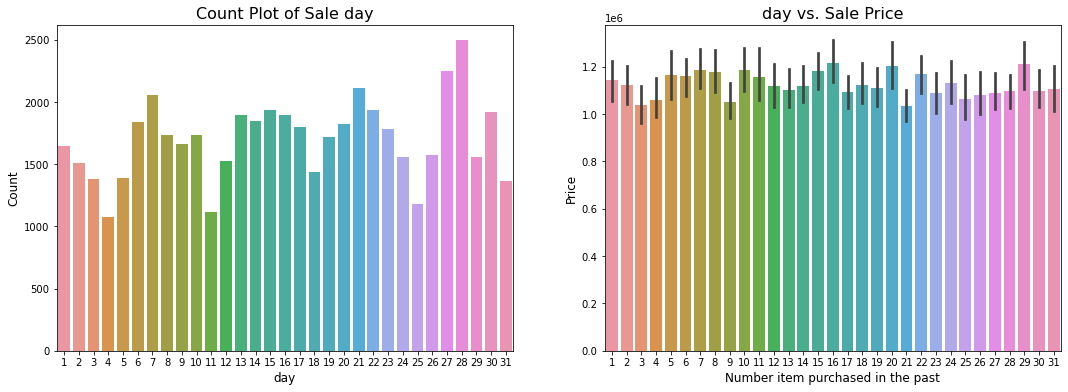

In [323]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


sns.countplot(x='day',data=df, ax=ax[0])
ax[0].set_xlabel('day', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Sale day', fontsize=16)


sns.barplot(x='day', y='SALE PRICE',data=df, ax=ax[1])
ax[1].set_xlabel('Number item purchased in the past', fontsize=12)
ax[1].set_ylabel('Price', fontsize=12)
ax[1].set_title('day vs. Sale Price', fontsize=16)
plt.show()

#### Week of day

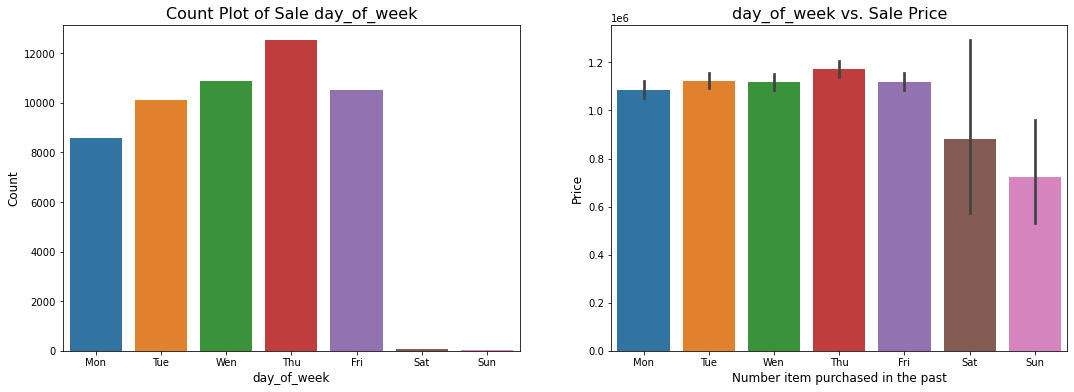

In [325]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))


labels = ['Mon', 'Tue', 'Wen', 'Thu','Fri','Sat', 'Sun']


sns.countplot(x='day_of_week',data=df, ax=ax[0])
ax[0].set_xlabel('day_of_week', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Sale day_of_week', fontsize=16)
ax[0].set_xticklabels(labels)


sns.barplot(x='day_of_week', y='SALE PRICE',data=df, ax=ax[1])
ax[1].set_xlabel('Number item purchased in the past', fontsize=12)
ax[1].set_ylabel('Price', fontsize=12)
ax[1].set_title('day_of_week vs. Sale Price', fontsize=16)
ax[1].set_xticklabels(labels)
plt.show()

### BUILDING CLASS CATEGORY (not useful)

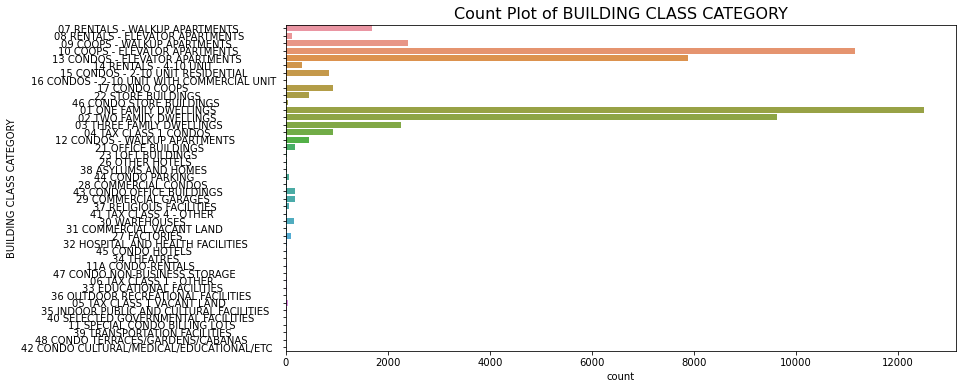

In [306]:
fig, ax = plt.subplots(figsize=(12,6))

sns.countplot(y='BUILDING CLASS CATEGORY',data=df)
# labels = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens','Staten Island']
# ax.set_xticklabels(labels)

ax.set_title('Count Plot of BUILDING CLASS CATEGORY',fontsize=16)

plt.show()

### NEIGHBORHOOD (problem)

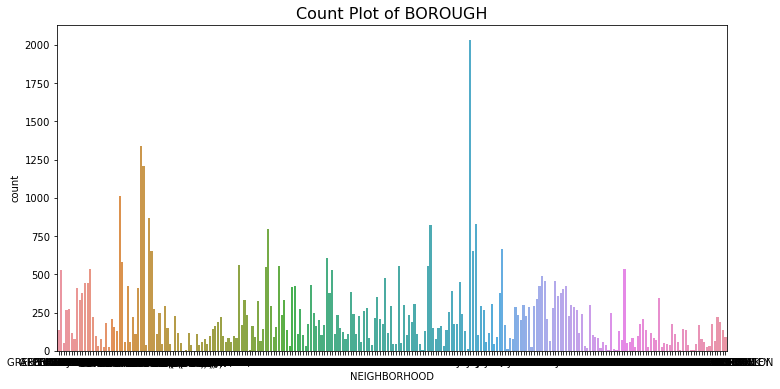

In [134]:
fig, ax = plt.subplots(figsize=(12,6))

sns.countplot(x='NEIGHBORHOOD',data=df)
ax.set_title('Count Plot of BOROUGH',fontsize=16)

plt.show()

# 04. Machine Learning Model

### par01: Data preparation

#### check the correlation between the features

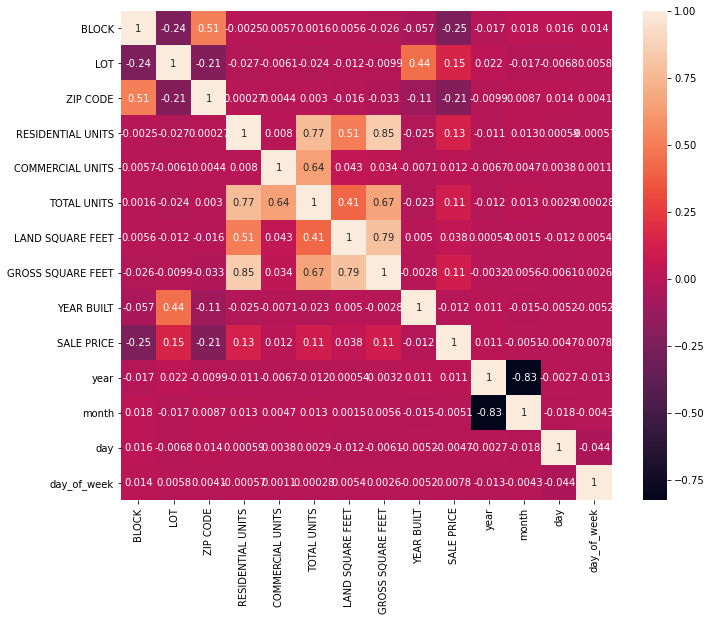

In [372]:
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True)

In [373]:
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
LOT                  0.146087
RESIDENTIAL UNITS    0.133086
GROSS SQUARE FEET    0.110081
TOTAL UNITS          0.109381
LAND SQUARE FEET     0.038076
COMMERCIAL UNITS     0.011552
year                 0.010903
day_of_week          0.007831
day                 -0.004655
month               -0.005110
YEAR BUILT          -0.011878
ZIP CODE            -0.214306
BLOCK               -0.248512
Name: SALE PRICE, dtype: float64

### create sub-dataset for models

In [508]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,year,month,day,day_of_week
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,5.973810,1.945910,C2,153 AVENUE B,,10009,1.791759,0.000000,1.791759,7.398786,8.770439,1900,2,C2,6625000.0,2017-07-19,2017,7,19,2
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,5.998937,3.091042,C4,154 EAST 7TH STREET,,10009,2.397895,0.000000,2.397895,7.728856,8.823942,1913,2,C4,3936272.0,2016-09-23,2016,9,23,4
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,6.003887,4.025352,C2,301 EAST 10TH STREET,,10009,1.945910,0.000000,1.945910,7.770645,8.437284,1900,2,C2,8000000.0,2016-11-17,2016,11,17,3
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,6.008813,3.496508,C4,210 AVENUE B,,10009,2.197225,0.000000,2.197225,7.467942,8.349248,1920,2,C4,3192840.0,2016-09-23,2016,9,23,4
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,5.961005,5.036953,D9,629 EAST 5TH STREET,,10009,3.218876,0.000000,3.218876,8.409608,9.826822,1920,2,D9,16232000.0,2016-11-07,2016,11,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84541,5,WOODROW,02 TWO FAMILY DWELLINGS,1,8.898092,4.844187,B2,112 ROBIN COURT,,10309,1.098612,0.000000,1.098612,9.313709,7.678326,1994,1,B2,648000.0,2016-12-07,2016,12,7,2
84543,5,WOODROW,02 TWO FAMILY DWELLINGS,1,8.902456,3.555348,B9,37 QUAIL LANE,,10309,1.098612,0.000000,1.098612,7.783641,7.853993,1998,1,B9,450000.0,2016-11-28,2016,11,28,0
84544,5,WOODROW,02 TWO FAMILY DWELLINGS,1,8.902456,4.369448,B9,32 PHEASANT LANE,,10309,1.098612,0.000000,1.098612,7.823646,7.774015,1998,1,B9,550000.0,2017-04-21,2017,4,21,4
84545,5,WOODROW,02 TWO FAMILY DWELLINGS,1,8.902728,4.110874,B2,49 PITNEY AVENUE,,10309,1.098612,0.000000,1.098612,8.294300,7.311218,1925,1,B2,460000.0,2017-07-05,2017,7,5,2


In [561]:
df_ml = df[['BOROUGH','TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'ZIP CODE','RESIDENTIAL UNITS', 
            'COMMERCIAL UNITS','TOTAL UNITS','LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT',
           'year','month','day','day_of_week','SALE PRICE']]
df_ml

,BOROUGH,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,year,month,day,day_of_week,SALE PRICE
0,1,2A,5.973810,1.945910,10009,1.791759,0.000000,1.791759,7.398786,8.770439,1900,2017,7,19,2,6625000.0
3,1,2B,5.998937,3.091042,10009,2.397895,0.000000,2.397895,7.728856,8.823942,1913,2016,9,23,4,3936272.0
4,1,2A,6.003887,4.025352,10009,1.945910,0.000000,1.945910,7.770645,8.437284,1900,2016,11,17,3,8000000.0
6,1,2B,6.008813,3.496508,10009,2.197225,0.000000,2.197225,7.467942,8.349248,1920,2016,9,23,4,3192840.0
9,1,2,5.961005,5.036953,10009,3.218876,0.000000,3.218876,8.409608,9.826822,1920,2016,11,7,0,16232000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84541,5,1,8.898092,4.844187,10309,1.098612,0.000000,1.098612,9.313709,7.678326,1994,2016,12,7,2,648000.0
84543,5,1,8.902456,3.555348,10309,1.098612,0.000000,1.098612,7.783641,7.853993,1998,2016,11,28,0,450000.0
84544,5,1,8.902456,4.369448,10309,1.098612,0.000000,1.098612,7.823646,7.774015,1998,2017,4,21,4,550000.0
84545,5,1,8.902728,4.110874,10309,1.098612,0.000000,1.098612,8.294300,7.311218,1925,2017,7,5,2,460000.0


#### transform the numeric features using log(x + 1)

In [562]:
numeric_cols = ['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']

In [563]:
from scipy.stats import skew
skewed = df_ml[numeric_cols].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
df_ml[skewed] = np.log1p(df[skewed])

In [564]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df_ml[numeric_cols])

for i, col in enumerate(numeric_cols):
       df_ml[col] = scaled[:,i]

In [565]:
df_ml

,BOROUGH,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,year,month,day,day_of_week,SALE PRICE
0,1,2A,-1.537176,-1.181669,-1.272548,1.761222,-0.211059,1.712913,0.122735,0.711104,-1.490207,2017,7,19,2,6625000.0
3,1,2B,-1.516609,-0.578409,-1.272548,2.358513,-0.211059,2.314415,0.247340,0.731491,-1.109114,2016,9,23,4,3936272.0
4,1,2A,-1.512557,-0.086211,-1.272548,1.924604,-0.211059,1.877447,0.263117,0.584154,-1.490207,2016,11,17,3,8000000.0
6,1,2B,-1.508525,-0.364808,-1.272548,2.173466,-0.211059,2.128063,0.148842,0.550608,-0.903910,2016,9,23,4,3192840.0
9,1,2,-1.547657,0.446705,-1.272548,3.016384,-0.211059,2.976923,0.504333,1.113641,-0.903910,2016,11,7,0,16232000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84541,5,1,0.856457,0.345155,-0.805492,0.893650,-0.211059,0.839225,0.845643,0.294951,1.265388,2016,12,7,2,648000.0
84543,5,1,0.860029,-0.333811,-0.805492,0.893650,-0.211059,0.839225,0.268022,0.361890,1.382648,2016,11,28,0,450000.0
84544,5,1,0.860029,0.095060,-0.805492,0.893650,-0.211059,0.839225,0.283125,0.331414,1.382648,2017,4,21,4,550000.0
84545,5,1,0.860252,-0.041157,-0.805492,0.893650,-0.211059,0.839225,0.460803,0.155064,-0.757336,2017,7,5,2,460000.0


#### one-hot-encoding for categorical column

In [566]:
dummy_tax = pd.get_dummies(df_ml[['TAX CLASS AT PRESENT']])
dummy_tax

,TAX CLASS AT PRESENT_,TAX CLASS AT PRESENT_1,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_3,TAX CLASS AT PRESENT_4
0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
84541,0,1,0,0,0,0,0,0,0,0,0
84543,0,1,0,0,0,0,0,0,0,0,0
84544,0,1,0,0,0,0,0,0,0,0,0
84545,0,1,0,0,0,0,0,0,0,0,0


In [567]:
df_ml = df_ml.drop(['TAX CLASS AT PRESENT'],axis=1)
df_ml = pd.concat([df_ml, dummy_tax] ,axis=1)

In [568]:
x = df_ml.drop('SALE PRICE', axis=1)
y = df_ml['SALE PRICE']

x.shape , y.shape

((52766, 25), (52766,))

In [569]:
x_train ,x_test, y_train , y_test = train_test_split(x , y , test_size = 0.3 , random_state =1)

In [570]:
x_train.shape, y_train.shape

((36936, 25), (36936,))

In [571]:
x_test.shape, y_test.shape

((15830, 25), (15830,))

## part02: building models

#### 01. Linear Regression

In [576]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
mae(y_test,y_pred_lr)

770828.8932771569

In [588]:
y_pred_lr = lr.predict(x_train)
mae(y_train,y_pred_lr)

757372.3427956654

In [577]:
## use K-fold method k=5
kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.
result = cross_val_score(lr, x, y, cv = kfold)
result = cross_val_score(lr, x, y, cv = kfold, scoring='neg_mean_absolute_error')
result.mean()*-1

764491.2526460696

#### 02. Lasso Regression

In [578]:
alpha=0.00099
laso = Lasso(alpha=alpha,max_iter=1000)
laso.fit(x_train, y_train)
y_pred_laso = laso.predict(x_test)
mae(y_test,y_pred_laso)

770929.1703094607

In [579]:
## use K-fold method k=5
kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.
result = cross_val_score(laso, x, y, cv = kfold)
result = cross_val_score(laso, x, y, cv = kfold, scoring='neg_mean_absolute_error')
result.mean()*-1

764479.0775794808

#### 03. Ridge Regression

In [582]:
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(x_train, y_train)
y_pred_ridge = ridge.predict(x_test)
mae(y_test,y_pred_ridge)

766235.4734824058

In [583]:
## use K-fold method k=5
kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.
result = cross_val_score(ridge, x, y, cv = kfold)
result = cross_val_score(ridge, x, y, cv = kfold, scoring='neg_mean_absolute_error')
result.mean()*-1

759946.3918560575

#### 04. DecisionTree Regressor

In [584]:
dtregressor = DecisionTreeRegressor() 
dtregressor.fit(x_train, y_train)
y_pred_dtregressor = dtregressor.predict(x_test)
mae(y_test,y_pred_dtregressor)

536951.9957645219

In [585]:
## use K-fold method k=5
kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.
result = cross_val_score(dtregressor, x, y, cv = kfold)
result = cross_val_score(dtregressor, x, y, cv = kfold, scoring='neg_mean_absolute_error')
result.mean()*-1

517584.9217277779

#### 05. RandomForest Regressor

In [586]:
rfregressor = RandomForestRegressor(n_estimators=500)
rfregressor.fit(x_train, y_train)
y_pred_rfregressor = rfregressor.predict(x_test)
mae(y_test,y_pred_rfregressor)

405711.3131404705

In [587]:
## use K-fold method k=5
kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.
result = cross_val_score(rfregressor, x, y, cv = kfold)
result = cross_val_score(rfregressor, x, y, cv = kfold, scoring='neg_mean_absolute_error')
result.mean()*-1

394700.6902408869

#### 06. Xgboost

In [611]:
data_dmatrix = xgb.DMatrix(data=x,label=y)

In [610]:
# for xgboost we need to convert "BOROUGH" column to string
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
x['BOROUGH'] = lbl.fit_transform(x['BOROUGH'].astype(str))
x_train['BOROUGH'] = lbl.fit_transform(x_train['BOROUGH'].astype(str))
x_test['BOROUGH'] = lbl.fit_transform(x_test['BOROUGH'].astype(str))

In [608]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 500)
xg_reg.fit(x_train,y_train)

y_pred_xg_reg = xg_reg.predict(x_test)
mae(y_test,y_pred_xg_reg)

[20:45:35] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


438728.2174414186

In [616]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=500, early_stopping_rounds=10,metrics="mae", 
                    as_pandas=True, verbose=True,seed=123)

[20:49:39] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:39] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:39] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:39] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:39] WARNING: d:\bld\xgboost-split_1619725139497\work\src\objective\regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [617]:
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,1.015267e+06,3965.454555,1.015302e+06,16399.699811
1,9.173134e+05,3410.808814,9.177864e+05,15661.125465
2,8.338916e+05,3862.060078,8.349462e+05,13856.129956
3,7.659439e+05,4772.702305,7.674626e+05,13340.814664
4,7.105481e+05,3819.328050,7.124978e+05,13579.468858
...,...,...,...,...
495,3.594412e+05,1347.387014,4.341665e+05,6134.592905
496,3.592783e+05,1318.599630,4.341121e+05,6154.296482
497,3.591856e+05,1266.583947,4.341211e+05,6151.537636
498,3.591092e+05,1256.652002,4.341058e+05,6154.849859


In [619]:
cv_results["test-mae-mean"].tail(1)

499    434122.75625
Name: test-mae-mean, dtype: float64

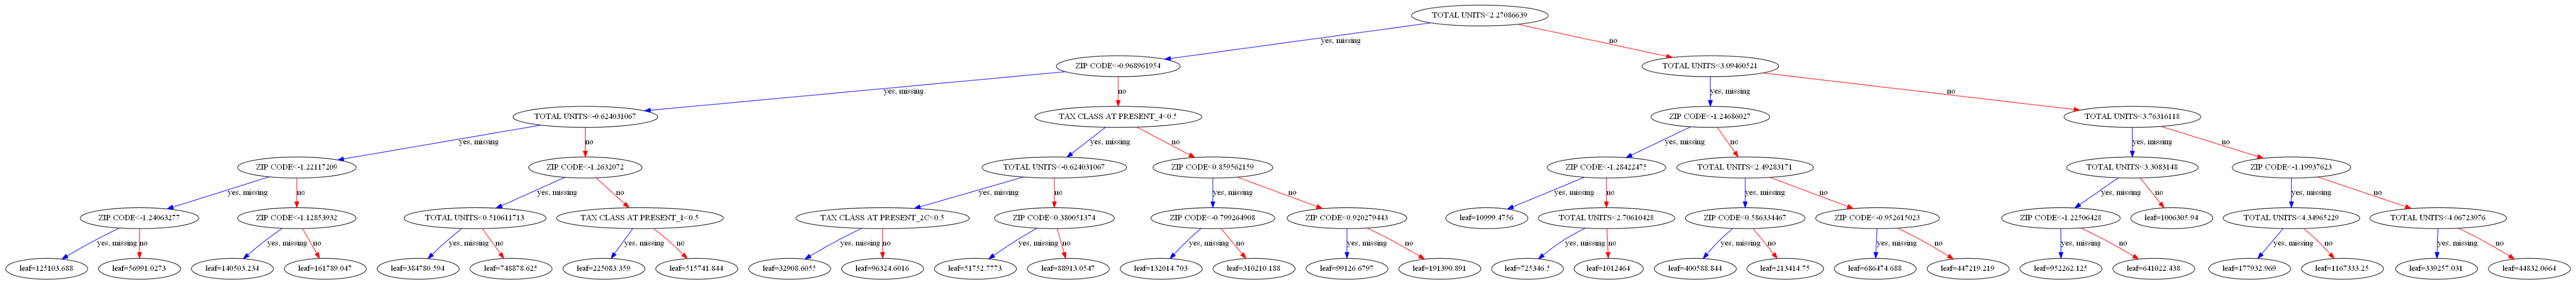

In [644]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 10]
plt.show()

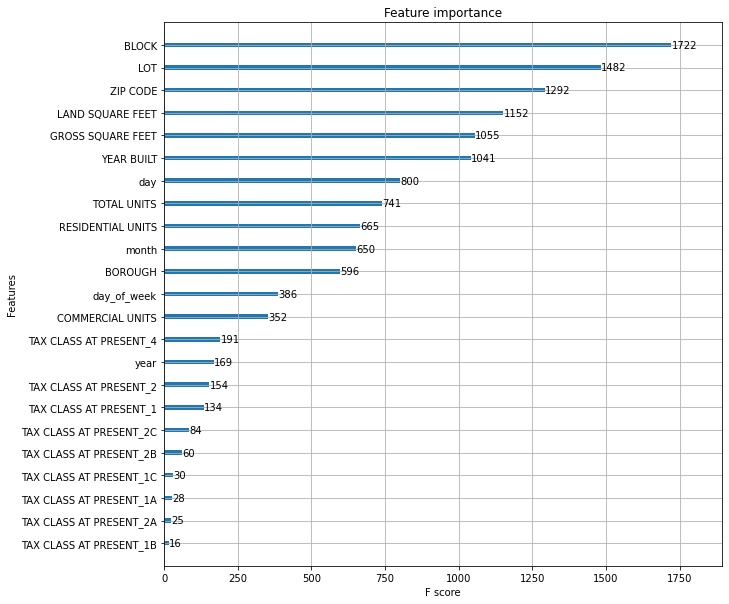

In [632]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [100, 10]
plt.show()

## Bonus: feature selection

In [435]:
df.drop('SALE PRICE', axis=1)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE,year,month,day,day_of_week
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633.0,6440.0,1900,2,C2,2017-07-19,2017,7,19,2
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272.0,6794.0,1913,2,C4,2016-09-23,2016,9,23,4
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369.0,4615.0,1900,2,C2,2016-11-17,2016,11,17,3
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,,10009,8,0,8,1750.0,4226.0,1920,2,C4,2016-09-23,2016,9,23,4
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,,10009,24,0,24,4489.0,18523.0,1920,2,D9,2016-11-07,2016,11,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84541,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7317,126,B2,112 ROBIN COURT,,10309,2,0,2,11088.0,2160.0,1994,1,B2,2016-12-07,2016,12,7,2
84543,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,B9,37 QUAIL LANE,,10309,2,0,2,2400.0,2575.0,1998,1,B9,2016-11-28,2016,11,28,0
84544,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,B9,32 PHEASANT LANE,,10309,2,0,2,2498.0,2377.0,1998,1,B9,2017-04-21,2017,4,21,4
84545,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,B2,49 PITNEY AVENUE,,10309,2,0,2,4000.0,1496.0,1925,1,B2,2017-07-05,2017,7,5,2


In [437]:
df['SALE PRICE']

0         6625000.0
3         3936272.0
4         8000000.0
6         3192840.0
9        16232000.0
            ...    
84541      648000.0
84543      450000.0
84544      550000.0
84545      460000.0
84546    11693337.0
Name: SALE PRICE, Length: 52766, dtype: float64

In [645]:
df_ml

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,year,month,day,day_of_week,SALE PRICE,TAX CLASS AT PRESENT_,TAX CLASS AT PRESENT_1,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_3,TAX CLASS AT PRESENT_4
0,1,-1.537176,-1.181669,-1.272548,1.761222,-0.211059,1.712913,0.122735,0.711104,-1.490207,2017,7,19,2,6625000.0,0,0,0,0,0,0,1,0,0,0,0
3,1,-1.516609,-0.578409,-1.272548,2.358513,-0.211059,2.314415,0.247340,0.731491,-1.109114,2016,9,23,4,3936272.0,0,0,0,0,0,0,0,1,0,0,0
4,1,-1.512557,-0.086211,-1.272548,1.924604,-0.211059,1.877447,0.263117,0.584154,-1.490207,2016,11,17,3,8000000.0,0,0,0,0,0,0,1,0,0,0,0
6,1,-1.508525,-0.364808,-1.272548,2.173466,-0.211059,2.128063,0.148842,0.550608,-0.903910,2016,9,23,4,3192840.0,0,0,0,0,0,0,0,1,0,0,0
9,1,-1.547657,0.446705,-1.272548,3.016384,-0.211059,2.976923,0.504333,1.113641,-0.903910,2016,11,7,0,16232000.0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84541,5,0.856457,0.345155,-0.805492,0.893650,-0.211059,0.839225,0.845643,0.294951,1.265388,2016,12,7,2,648000.0,0,1,0,0,0,0,0,0,0,0,0
84543,5,0.860029,-0.333811,-0.805492,0.893650,-0.211059,0.839225,0.268022,0.361890,1.382648,2016,11,28,0,450000.0,0,1,0,0,0,0,0,0,0,0,0
84544,5,0.860029,0.095060,-0.805492,0.893650,-0.211059,0.839225,0.283125,0.331414,1.382648,2017,4,21,4,550000.0,0,1,0,0,0,0,0,0,0,0,0
84545,5,0.860252,-0.041157,-0.805492,0.893650,-0.211059,0.839225,0.460803,0.155064,-0.757336,2017,7,5,2,460000.0,0,1,0,0,0,0,0,0,0,0,0


In [646]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=11,
          forward=True,
          floating=False,
          scoring = 'neg_root_mean_squared_error',
          cv = 0)
sfs.fit(df_ml.drop('SALE PRICE', axis=1), df_ml['SALE PRICE'])
sfs.k_feature_names_

('BOROUGH',
 'BLOCK',
 'LOT',
 'COMMERCIAL UNITS',
 'TOTAL UNITS',
 'GROSS SQUARE FEET',
 'TAX CLASS AT PRESENT_1',
 'TAX CLASS AT PRESENT_1A',
 'TAX CLASS AT PRESENT_2A',
 'TAX CLASS AT PRESENT_2B',
 'TAX CLASS AT PRESENT_4')

# QA

### Q1. How does an area of choice affect the closing price of buildings? 
A: Manhattan has the highest building price, Bronx has the lowest price

### Q2. How does the season affect the closing price of a property? 

###  Q3. What is the average closing price based on the neighborhood? 

###  Q4. What is the average year built based on the neighborhood? 

###  Q5. What is the distribution of sales over the months? 

###  Q6. What is the common type of house of each neighborhood? 